<a href="https://colab.research.google.com/github/pincesslucy/spaceship-titanic/blob/main/starship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Learning 프로젝트 수행을 위한 코드 구조화

`(분류, 회귀 Task)`

- ML project를 위해서 사용하는 템플릿 코드를 만듭니다.

1. **필요한 라이브러리와 데이터를 불러옵니다.**


2. **EDA를 수행합니다.** 이 때 EDA의 목적은 풀어야하는 문제를 위해서 수행됩니다.


3. **전처리를 수행합니다.** 이 때 중요한건 **feature engineering**을 어떻게 하느냐 입니다.


4. **데이터 분할을 합니다.** 이 때 train data와 test data 간의 분포 차이가 없는지 확인합니다.


5. **학습을 진행합니다.** 어떤 모델을 사용하여 학습할지 정합니다. 성능이 잘 나오는 GBM을 추천합니다.


6. **hyper-parameter tuning을 수행합니다.** 원하는 목표 성능이 나올 때 까지 진행합니다. 검증 단계를 통해 지속적으로 **overfitting이 되지 않게 주의**하세요.


7. **최종 테스트를 진행합니다.** 데이터 분석 대회 포맷에 맞는 submission 파일을 만들어서 성능을 확인해보세요.

## 1. 라이브러리, 데이터 불러오기

In [ ]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMClassifier
from lightgbm.sklearn import LGBMRegressor

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
#import optuna

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/data/spaceship-titanic/'

In [ ]:
# 데이터를 불러옵니다.
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')

In [ ]:
train = train.drop(columns=['PassengerId', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Cabin'])

In [ ]:
test = test.drop(columns=['PassengerId', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Cabin'])

In [ ]:
train

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,True
...,...,...,...,...,...,...,...
8688,Europa,False,A/98/P,55 Cancri e,41.0,True,False
8689,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,False
8690,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,True
8691,Europa,False,E/608/S,55 Cancri e,32.0,False,False


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HomePlanet   8492 non-null   object 
 1   CryoSleep    8476 non-null   object 
 2   Cabin        8494 non-null   object 
 3   Destination  8511 non-null   object 
 4   Age          8514 non-null   float64
 5   VIP          8490 non-null   object 
 6   Transported  8693 non-null   bool   
dtypes: bool(1), float64(1), object(5)
memory usage: 416.1+ KB


In [ ]:
train.Transported.value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

## 2. EDA

- 데이터에서 찾아야 하는 기초적인 내용들을 확인합니다.


- class imbalance, target distribution, outlier, correlation을 확인합니다.

<Axes: xlabel='Age', ylabel='Count'>

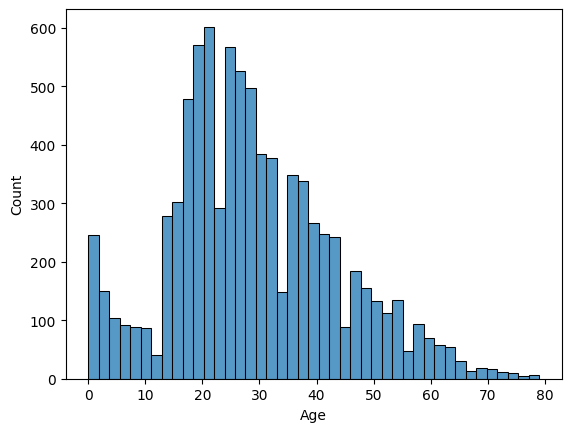

In [ ]:
## On your Own
sns.histplot(train['Age'])

이런 식으로 여러가지 그래프를 그려가며, 데이터에 대한 인사이트를 얻습니다!

### 3. 전처리

#### 결측치 처리

#### 다중공선성 처리

#### Encoding Categorical Features

In [ ]:
# dtype이 object인 변수들 처리.
train_OHE = pd.get_dummies(train, columns=['HomePlanet', 'CryoSleep', 'Destination', 'VIP'])
test_OHE = pd.get_dummies(test, columns=['HomePlanet', 'CryoSleep', 'Destination', 'VIP'])

#### feature extraction

- 차원의 저주를 해결하거나, 데이터의 feature 조합을 이용하는 새로운 feature를 생성할 때, PCA를 사용합니다.

- 분석에 사용할 feature를 선택하는 과정도 포함합니다.

### 4. 학습 데이터 분할

In [ ]:
# 첫번째 테스트용으로 사용하고, 실제 학습시에는 K-Fold CV를 사용합니다.
# train : test = 8 : 2
# from sklearn.model_selection import train_test_split

X_train = train_OHE.drop(columns='Transported')
y_train = train_OHE.Transported

X_test = test_OHE


In [ ]:
X_train

,Age,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True
0,39.0,0,1,0,1,0,0,0,1,1,0
1,24.0,1,0,0,1,0,0,0,1,1,0
2,58.0,0,1,0,1,0,0,0,1,0,1
3,33.0,0,1,0,1,0,0,0,1,1,0
4,16.0,1,0,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
8688,41.0,0,1,0,1,0,1,0,0,0,1
8689,18.0,1,0,0,0,1,0,1,0,1,0
8690,26.0,1,0,0,1,0,0,0,1,1,0
8691,32.0,0,1,0,1,0,1,0,0,1,0


In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        4186 non-null   float64
 1   HomePlanet_Earth           4277 non-null   uint8  
 2   HomePlanet_Europa          4277 non-null   uint8  
 3   HomePlanet_Mars            4277 non-null   uint8  
 4   CryoSleep_False            4277 non-null   uint8  
 5   CryoSleep_True             4277 non-null   uint8  
 6   Destination_55 Cancri e    4277 non-null   uint8  
 7   Destination_PSO J318.5-22  4277 non-null   uint8  
 8   Destination_TRAPPIST-1e    4277 non-null   uint8  
 9   VIP_False                  4277 non-null   uint8  
 10  VIP_True                   4277 non-null   uint8  
dtypes: float64(1), uint8(10)
memory usage: 75.3 KB


### 5. 학습 및 평가

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [ ]:
pipe_model = Pipeline([
               ('scaler', MinMaxScaler()),
               ('model', LGBMClassifier())
            ])

In [ ]:
# 간단하게 LightGBM 테스트
# 적당한 hyper-parameter 조합을 두었습니다. (항상 best는 아닙니다. 예시입니다.)

from sklearn.model_selection import GridSearchCV
hyper_param = {
    "model__max_depth" : [8, 16, None],
    "model__n_estimators" : [100, 300, 500],
    "model__max_bin" : [20],
    "model__learning_rate" : [0.001, 0.0025, 0.003],
    "model__objective" : ["regression"],
    "model__boosting_type" : ["gbdt"],
    "model__metric" : ["mae"],
    "model__sub_feature" : [0.345],
    "model__bagging_fraction" : [0.7, 0.75, 0.85],
    "model__bagging_freq" : [40],
    "model__num_leaves" : [256, 512],
    "model__min_data" : [500],
    "model__verbose" : [-1], # 필수
    "model__min_hessian" : [0.05],
    "model__feature_fraction_seed" : [2],
    "model__bagging_seed" : [3]
}

grid_model = GridSearchCV(pipe_model, param_grid=hyper_param, cv=5, n_jobs=-1, scoring='accuracy')
grid_model.fit(X_train, y_train)
best_model = grid_model.best_estimator_

In [ ]:
print(grid_model.best_params_)
print(grid_model.best_score_)

{'model__bagging_fraction': 0.85, 'model__bagging_freq': 40, 'model__bagging_seed': 3, 'model__boosting_type': 'gbdt', 'model__feature_fraction_seed': 2, 'model__learning_rate': 0.0025, 'model__max_bin': 20, 'model__max_depth': 8, 'model__metric': 'mae', 'model__min_data': 500, 'model__min_hessian': 0.05, 'model__n_estimators': 300, 'model__num_leaves': 256, 'model__objective': 'regression', 'model__sub_feature': 0.345, 'model__verbose': -1}
0.7239180222751459


In [ ]:
# metric은 그때마다 맞게 바꿔줘야 합니다.
evaluation_metric = 

### 6. Hyper-parameter Tuning

> GridSearchCV

** LightGBM의 hyperparameter **

[Official Documentation] https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html 

[Blog 1] https://smecsm.tistory.com/133

[Blog 2] https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

[Blog 3] https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/

In [ ]:
# GridSearchCV를 이용하여 가장 좋은 성능을 가지는 모델을 찾아봅시다. (이것은 첫번째엔 선택입니다.)
# Lightgbm은 hyper-parameter의 영향을 많이 받기 때문에, 저는 보통 맨처음에 한번 정도는 가볍게 GCV를 해봅니다.
# 성능 향상이 별로 없다면, lightgbm으로 돌린 대략적인 성능이 이 정도라고 생각하면 됩니다.
# 만약 성능 향상이 크다면, 지금 데이터는 hyper-parameter tuning을 빡빡하게 하면 성능 향상이 많이 이끌어 낼 수 있습니다.

from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth" : [8, 16, None],
    "n_estimators" : [100, 300, 500],
    "max_bin" : [20],
    "learning_rate" : [0.001, 0.0025, 0.003],
    "objective" : ["regression"],
    "boosting_type" : ["gbdt"],
    "metric" : ["mae"],
    "sub_feature" : [0.345],
    "bagging_fraction" : [0.7, 0.75, 0.85],
    "bagging_freq" : [40],
    "num_leaves" : [256, 512],
    "min_data" : [500],
    "verbose" : [-1], # 필수
    "min_hessian" : [0.05],
    "feature_fraction_seed" : [2],
    "bagging_seed" : [3]
}


gcv = GridSearchCV(estimator=model, param_grid=param_grid, cv=5,
                  n_jobs=-1, verbose=1)

gcv.fit(X_train, y_train)
print("Best Estimator : ", gcv.best_estimator_)

In [ ]:
print("Prediction with Best Estimator")
gcv_pred_train = gcv.predict(X_train)
gcv_pred_test = gcv.predict(x_test)

gcv_train_score = evaluation_metric(y_train, gcv_pred_train)
gcv_test_score = evaluation_metric(y_test, gcv_pred_test)

print("Train MAE Score : %.4f" % gcv_train_score)
print("Test MAE Score : %.4f" % gcv_test_score)

In [ ]:
print("Performance Gain") # 이걸로 성능 향상 확인.
print("in train : ", (train_score - gcv_train_score))
print("in test : ", (test_score - gcv_test_score))

> optuna를 사용해봅시다 !

In [ ]:
def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    n_estimators = 
    max_depth = 
    max_features = 
    
    
    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = RandomForestRegressor(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 max_features=max_features)
    
    
    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K)
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        loss = mean_absolute_error(y_val, preds)
        losses.append(loss)
    
    
    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(losses)

In [ ]:
K = # Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K)

study = optuna.create_study(direction="minimize") # 최소/최대 어느 방향의 최적값을 구할 건지.
study.optimize(opt_func, n_trials=5)

In [ ]:
# optuna가 시도했던 모든 실험 관련 데이터
study.trials_dataframe()

In [ ]:
print("Best Score: %.4f" % study.best_value) # best score 출력
print("Best params: ", study.best_trial.params) # best score일 때의 하이퍼파라미터들

In [ ]:
# 실험 기록 시각화
optuna.visualization.plot_optimization_history(study)

In [ ]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(study)

### 7. 테스트 및 제출 파일 생성

In [ ]:
y_test_pred = best_model.predict(X_test)

In [ ]:
X_test # 원본 데이터랑 id가 맞는지 확인 해보기!

In [ ]:
submission = pd.read_csv(path + "sample_submission.csv")
submission['Transported'] = y_test_pred
submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,False


In [ ]:
submission.to_csv("submission.csv", index=False)